## Import Modules

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d adityajn105/flickr8k

 99% 1.03G/1.04G [00:11<00:00, 131MB/s]
100% 1.04G/1.04G [00:11<00:00, 96.3MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/flickr8k.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [5]:
!unzip '/content/working.zip'
!unzip '/content/cap_dir.zip'

Archive:  /content/working.zip
   creating: working/
Archive:  /content/cap_dir.zip
   creating: cap_dir/
  inflating: cap_dir/captions.txt    


In [6]:
images = '/content/Images'
working_dir = '/content/working'
cap_dir = '/content/cap_dir'

## Extract Image Features

In [7]:
model = VGG16(weights='imagenet')
new_input = model.input
hidden_layer = model.layers[-2].output
model = Model(inputs=new_input, outputs=hidden_layer)
model.summary()

553467096/553467096 [==============================] - 6s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [8]:
features = {}
# Define the target size for resizing images
target_size = (224, 224)  # Set the target size to (224, 224) to match the model's input size

# Iterate through the image files in the directory
directory = os.path.join(images)

for img_name in tqdm(os.listdir(directory)):
    img_path = os.path.join(directory, img_name)  # Use os.path.join to construct paths
    image = load_img(img_path, target_size=target_size)  # Resize to (224, 224)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)  # Add a batch dimension
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)  # Removed verbose
    image_id = img_name.split('.')[0]
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [9]:
# store features in pickle
pickle.dump(features, open(os.path.join(working_dir, 'features.pkl'), 'wb'))

In [10]:
#load features from pickle
with open(os.path.join(working_dir, 'features.pkl'), 'rb') as f:
  features = pickle.load(f)


## Load the Captions Data

In [11]:
with open(os.path.join(cap_dir, 'captions.txt'), 'r') as f:
  next(f)
  captions_doc = f.read()



In [12]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [13]:
len(mapping)

8091

## Preprocess Text Data

In [14]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [15]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [16]:
# preprocess the text
clean(mapping)

In [17]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [18]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [19]:
len(all_captions)

40455

In [20]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [21]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [22]:
vocab_size

8485

In [23]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

## Train Test Split

In [24]:
image_ids = list(mapping.keys())

# Define the number of samples you want for training and testing
total_samples = 5000  # Total number of samples you want to use
train_samples = int(total_samples * 0.9)  # 90% for training

# Shuffle the image IDs to randomize the selection
import random
random.shuffle(image_ids)

# Split the image IDs into training and testing sets
train = image_ids[:train_samples]
test = image_ids[train_samples:total_samples]

# You can also check the number of samples in each set
print(f"Number of training samples: {len(train)}")
print(f"Number of testing samples: {len(test)}")


Number of training samples: 4500
Number of testing samples: 500


In [25]:
# startseq girl going into wooden building endseq
#        X                   y
# startseq                   girl
# startseq girl              going
# startseq girl going        into
# ...........
# startseq girl going into wooden building      endseq

In [26]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

## Model Creation

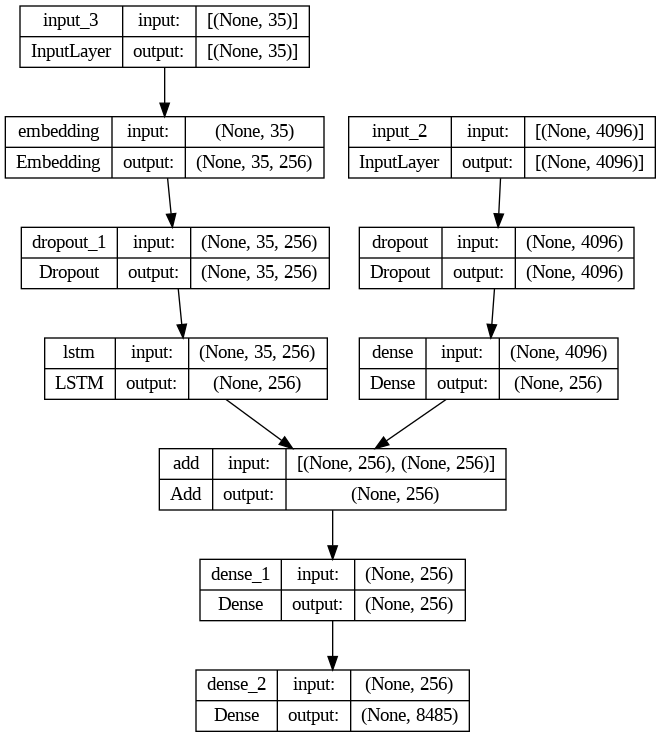

In [27]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.2)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
learning_rate = 0.001
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
optimizer = Adam(learning_rate = learning_rate)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

early_stopping = EarlyStopping(monitor='loss',
                               patience=5,
                               restore_best_weights=True)

model_checkpoint = ModelCheckpoint('best_image_captioning_model.h5',
                                   save_best_only=True)




# plot the model
plot_model(model, show_shapes=True)

In [28]:
# Define batch size and epochs
batch_size = 32  # You can adjust this based on your available memory
epochs = 15      # Adjust based on training performance

# Create data generator instances for training and validation
train_data_generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)


# Train the model
history = model.fit(train_data_generator, steps_per_epoch=len(train) // batch_size,
                    epochs=epochs, callbacks=[early_stopping, model_checkpoint], verbose=1)

# Save the trained model
model.save('image_captioning_model.h5')


Epoch 1/15
140/140 [==============================] - ETA: 0s - loss: 5.5221

140/140 [==============================] - 68s 439ms/step - loss: 5.5221
Epoch 2/15
140/140 [==============================] - ETA: 0s - loss: 4.3541

140/140 [==============================] - 48s 343ms/step - loss: 4.3541
Epoch 3/15
140/140 [==============================] - ETA: 0s - loss: 3.7960

140/140 [==============================] - 48s 342ms/step - loss: 3.7960
Epoch 4/15
140/140 [==============================] - ETA: 0s - loss: 3.4799

140/140 [==============================] - 44s 317ms/step - loss: 3.4799
Epoch 5/15
140/140 [==============================] - ETA: 0s - loss: 3.2607

140/140 [==============================] - 45s 324ms/step - loss: 3.2607
Epoch 6/15
140/140 [==============================] - ETA: 0s - loss: 3.0885

140/140 [==============================] - 48s 342ms/step - loss: 3.0885
Epoch 7/15
140/140 [==============================] - ETA: 0s - loss: 2.9423

140/140 [==============================] - 46s 331ms/step - loss: 2.9423
Epoch 8/15
140/140 [==============================] - ETA: 0s - loss: 2.8190

140/140 [==============================] - 45s 321ms/step - loss: 2.8190
Epoch 9/15
140/140 [==============================] - ETA: 0s - loss: 2.7117

140/140 [==============================] - 46s 330ms/step - loss: 2.7117
Epoch 10/15
140/140 [==============================] - ETA: 0s - loss: 2.6263

140/140 [==============================] - 44s 315ms/step - loss: 2.6263
Epoch 11/15
140/140 [==============================] - ETA: 0s - loss: 2.5517

140/140 [==============================] - 43s 305ms/step - loss: 2.5517
Epoch 12/15
140/140 [==============================] - ETA: 0s - loss: 2.4789

140/140 [==============================] - 44s 314ms/step - loss: 2.4789
Epoch 13/15
140/140 [==============================] - ETA: 0s - loss: 2.4134

140/140 [==============================] - 44s 312ms/step - loss: 2.4134
Epoch 14/15
140/140 [==============================] - ETA: 0s - loss: 2.3555

140/140 [==============================] - 46s 332ms/step - loss: 2.3555
Epoch 15/15
140/140 [==============================] - ETA: 0s - loss: 2.3048

140/140 [==============================] - 44s 316ms/step - loss: 2.3048


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [58]:
# Save the tokenizer
with open('tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)


## Generate Captions for the Image

In [33]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [34]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break

    return in_text

In [60]:

from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/500 [00:00<?, ?it/s]

AttributeError: ignored

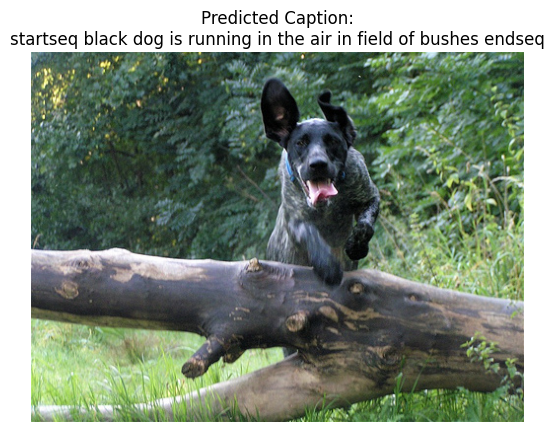

In [51]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


# Load your trained model
model = load_model('image_captioning_model.h5')

# Load the tokenizer used during training
tokenizer = Tokenizer()
tokenizer.word_index = pickle.load(open('tokenizer.pkl', 'rb'))

# Assuming you've already loaded the model and tokenizer as mentioned earlier

# Load the image you want to generate a caption for
image_path = '/content/1015584366_dfcec3c85a.jpg'  # Replace with the path to your image
image_id = os.path.splitext(os.path.basename(image_path))[0]  # Extract image ID
image_features = features.get(image_id)  # Get the extracted features for the image

if image_features is not None:
    # Generate a caption for the image using the extracted features
    max_length = 35  # Adjust this based on your model's max sequence length
    caption = predict_caption(model, image_features, tokenizer.word_index, max_length)

    # Load and display the image
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')  # Hide axis labels and ticks

    # Print the predicted caption
    plt.title("Predicted Caption:\n" + caption)
    plt.show()
else:
    print("Image features not found.")


## Test with Real Image

In [52]:
# vgg_model = VGG16()
# # restructure the model
# vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

In [53]:
# image_path = '/content/viber_image_2023-09-28_12-40-43-417.jpg'
# # load image
# image = load_img(image_path, target_size=(224, 224))
# # convert image pixels to numpy array
# image = img_to_array(image)
# # reshape data for model
# image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# # preprocess image for vgg
# image = preprocess_input(image)
# # extract features
# feature = vgg_model.predict(image, verbose=0)
# # predict from the trained model
# predict_caption(model, feature, tokenizer, max_length)